In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

import sys
sys.path.append("C:/Users/cnava/Repos/PolaPy")

from polapy.competitiveness import blais_lago, endersby_etal, grofman_selb, navarrete_etal as competitiveness
from polapy.polarization import navarrete_etal as polarization, esteban_ray

In this notebook, we propose an algoritmic implementation for calculating the antagonism of candidate $i$ by using different definitions of polarization.

In [2]:
class ElectionAgent(Agent):
    """ An agent in an election model."""
    def __init__(self, unique_id, model, candidates, p):
        super().__init__(unique_id, model)
        self.choice = np.random.choice(candidates, 1, p=p)

    def step(self):
        pass

class ElectionModel(Model):
    def __init__(self, N=1000, candidates=["A"], p=[1], width=10, height=10) -> None:
        self.num_agents = N
        self.n_candidates = len(candidates)
        self.candidates = candidates
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, True)

        for i in range(self.num_agents):
            a = ElectionAgent(i, self, candidates=candidates, p=p)
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(          
            agent_reporters={"State": "state"})
        
    def step(self):
        """Advance the model by one step."""

        # The model's step will go here for now this will call the step method of each agent and print the agent's unique_id
        self.schedule.step()

In [3]:
model = ElectionModel(N=10000, candidates=["A", "B", "C"], p=[0.1, 0.2, 0.7])
model.step()

df = pd.DataFrame([x.choice for x in model.schedule.agents], columns=["candidate"])
df["votes"] = 1
df.head()

,candidate,votes
0,C,1
1,C,1
2,B,1
3,C,1
4,B,1


In [4]:
data = df.groupby("candidate").agg({"votes": "sum"}).reset_index()
data["share"] = data["votes"] / data["votes"].sum()

data

,candidate,votes,share
0,A,998,0.0998
1,B,2005,0.2005
2,C,6997,0.6997


In [5]:
blais_lago(data, candidate="candidate", votes="votes", n_seats=5, system="smp")

(5.4955,
   candidate  votes   share  seats   value
 0         A    998  0.0998   5999  2.9995
 1         B   2005  0.2005   4992  2.4960
 2         C   6997  0.6997      0  0.0000)

In [6]:
candidates = list("abcdefghijklmnopqrstuvw")[0:2]

output = []
polling_id = 1
for loop in range(3):
    for candidate_a in candidates:
        for candidate_b in candidates:
            rate = 0 if candidate_a != candidate_b else 1
            rate = 1/len(candidates)
            output.append({
                "candidate": candidate_b,
                "rate": rate,
                "polling_id": polling_id
            })
        polling_id += 1

df = pd.DataFrame(output)
df["value"] = df["rate"] * 100
df

,candidate,rate,polling_id,value
0,a,0.5,1,50.0
1,b,0.5,1,50.0
2,a,0.5,2,50.0
3,b,0.5,2,50.0
4,a,0.5,3,50.0
5,b,0.5,3,50.0
6,a,0.5,4,50.0
7,b,0.5,4,50.0
8,a,0.5,5,50.0
9,b,0.5,5,50.0


In [7]:
blais_lago(df, candidate="candidate", votes="value", system="smp")

(0.0,
    candidate  rate  polling_id  value  seats
 0          a   0.5           1    0.0    0.0
 1          b   0.5           1    0.0    0.0
 2          a   0.5           2    0.0    0.0
 3          b   0.5           2    0.0    0.0
 4          a   0.5           3    0.0    0.0
 5          b   0.5           3    0.0    0.0
 6          a   0.5           4    0.0    0.0
 7          b   0.5           4    0.0    0.0
 8          a   0.5           5    0.0    0.0
 9          b   0.5           5    0.0    0.0
 10         a   0.5           6    0.0    0.0
 11         b   0.5           6    0.0    0.0)

In [11]:
df

,candidate,rate,polling_id,value
0,a,0.5,1,50.0
1,b,0.5,1,50.0
2,a,0.5,2,50.0
3,b,0.5,2,50.0
4,a,0.5,3,50.0
5,b,0.5,3,50.0
6,a,0.5,4,50.0
7,b,0.5,4,50.0
8,a,0.5,5,50.0
9,b,0.5,5,50.0


In [14]:
df.groupby("candidate").apply(lambda x: esteban_ray(x, pi="value", y="rate"))

candidate
a    0.0
b    0.0
dtype: float64

In [15]:
# df.groupby("candidate").apply(lambda x: tsui_wang(x))

## Generates synthetic data
For each combination of $\mu$ and $\sigma$, we generated 100 elections

In [17]:
import random

output = []
epi = {}
idx = 1
for iteration in range(5):
    for mu in [0.5, 0.66, 0.75, 0.8333, 1]:
        for sigma in [0.0025, 0.05, 0.10, 0.25]:
        
            distribution = [random.gauss(mu=mu, sigma=sigma) for x in range(100)]

            df_a = pd.DataFrame(distribution, columns=["rate"])
            df_a["candidate"] = "A"
            df_a["polling_id"] = range(df_a.shape[0])
            df_a.loc[df_a["rate"] <= 0, "rate"] = 0
            df_a.loc[df_a["rate"] >= 1, "rate"] = 1

            df_a["rate3"] = df_a["rate"].copy()
            df_a["rate2"] = df_a["rate"].apply(lambda x: np.round(x, 2))
            df_a["rate"] = df_a["rate"].apply(lambda x: x - x%0.01)

            df_b = df_a.copy()
            df_b["candidate"] = "B"
            df_b["rate"] = 1 - df_b["rate"]

            df = pd.concat([df_a, df_b], ignore_index=True)
            df["election_id"] = idx + 1
            idx += 1
            df["votes"] = df["rate"] * 100
            df["mu"] = mu
            df["sigma"] = sigma
            output.append(df)
            bw, ant = competitiveness(df, unit="polling_id")
            wt, ant = polarization(df, unit="polling_id")
            epi[idx + 1] = {
                "ep": wt,
                "ec": bw,
            }

df = pd.concat(output, ignore_index=True)
df.head()

,rate,candidate,polling_id,rate3,rate2,election_id,votes,mu,sigma
0,0.49,A,0,0.497571,0.5,2,49.0,0.5,0.0025
1,0.50,A,1,0.500951,0.5,2,50.0,0.5,0.0025
2,0.50,A,2,0.501356,0.5,2,50.0,0.5,0.0025
3,0.50,A,3,0.502631,0.5,2,50.0,0.5,0.0025
4,0.49,A,4,0.497674,0.5,2,49.0,0.5,0.0025


In [18]:
blais_lago(df.query("election_id == 44").groupby("candidate").sum(), candidate="candidate", votes="votes", system="smp")

(0.0468,
             rate  polling_id      rate3  rate2  election_id   votes    mu  \
 candidate                                                                   
 A          47.66        4950  48.180315  48.17         4400  4766.0  50.0   
 B          52.34        4950  48.180315  48.17         4400  5234.0  50.0   
 
            sigma  seats   value  
 candidate                        
 A           10.0  468.0  0.0468  
 B           10.0    0.0  0.0000  )

In [19]:
df.query("election_id == 44").groupby("candidate").sum()

,rate,polling_id,rate3,rate2,election_id,votes,mu,sigma
candidate,,,,,,,,
A,47.66,4950,48.180315,48.17,4400,4766.0,50.0,10.0
B,52.34,4950,48.180315,48.17,4400,5234.0,50.0,10.0


In [20]:
df_ER = df.groupby(["election_id", "candidate"]).apply(lambda x: esteban_ray(x, alpha=0.25, pi="votes", y="rate")).groupby(level=[0]).sum()\
    .reset_index().rename(columns={0: "value"})

df_ER = pd.merge(df_ER, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")
df_ER.head()

,election_id,value,mu,sigma
0,2,0.003116,0.50,0.0025
1,3,0.033682,0.50,0.0500
2,4,0.072427,0.50,0.1000
3,5,0.156110,0.50,0.2500
4,6,0.003077,0.66,0.0025


In [21]:
# df_RQ = df.groupby(["election_id", "candidate"]).apply(lambda x: reynal_querol(x)).groupby(level=[0]).sum()\
#     .reset_index().rename(columns={0: "value"})
# df_RQ = pd.merge(df_RQ, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")
# df_RQ.head()

In [23]:
df_ER2 = df.groupby(["election_id", "candidate"]).apply(lambda x: esteban_ray(x, alpha=1, pi="votes", y="rate")).groupby(level=[0]).sum()\
    .reset_index().rename(columns={0: "value"})
df_ER2 = pd.merge(df_ER2, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")
df_ER2.head()

,election_id,value,mu,sigma
0,2,0.000099,0.50,0.0025
1,3,0.001074,0.50,0.0500
2,4,0.002375,0.50,0.1000
3,5,0.005879,0.50,0.2500
4,6,0.000097,0.66,0.0025


In [29]:
df_DP = df.groupby(["election_id", "candidate"]).agg({"rate": "std"}).groupby(level=[0]).sum()\
    .reset_index().rename(columns={"rate": "value"})
df_DP = pd.merge(df_DP, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")

df_DP.head()

,election_id,value,mu,sigma
0,2,0.009978,0.50,0.0025
1,3,0.096148,0.50,0.0500
2,4,0.207505,0.50,0.1000
3,5,0.478790,0.50,0.2500
4,6,0.009921,0.66,0.0025


In [25]:
df_BW = df.groupby(["election_id"]).apply(lambda x: competitiveness(x, score="rate", unit="polling_id")[0]).groupby(level=[0]).sum()\
    .reset_index().rename(columns={0: "value"})
df_BW = pd.merge(df_BW, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")

df_BW.head()

,election_id,value,mu,sigma
0,2,0.991201,0.50,0.0025
1,3,0.924407,0.50,0.0500
2,4,0.834602,0.50,0.1000
3,5,0.615853,0.50,0.2500
4,6,0.691633,0.66,0.0025


In [26]:
df_WT = df.groupby(["election_id"]).apply(lambda x: polarization(x, score="rate", unit="polling_id")[0]).groupby(level=[0]).sum()\
    .reset_index().rename(columns={0: "value"})
df_WT = pd.merge(df_WT, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")

df_WT.head()

,election_id,value,mu,sigma
0,2,0.009856,0.50,0.0025
1,3,0.076078,0.50,0.0500
2,4,0.165446,0.50,0.1000
3,5,0.383517,0.50,0.2500
4,6,0.009739,0.66,0.0025


In [ ]:
# df_TW2 = df.groupby(["election_id", "candidate"]).apply(lambda x: tsui_wang(x, gamma=0.75)).groupby(level=[0]).sum()\
#     .reset_index().rename(columns={0: "value"})

# df_TW2 = pd.merge(df_TW2, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")
# df_TW2.head()

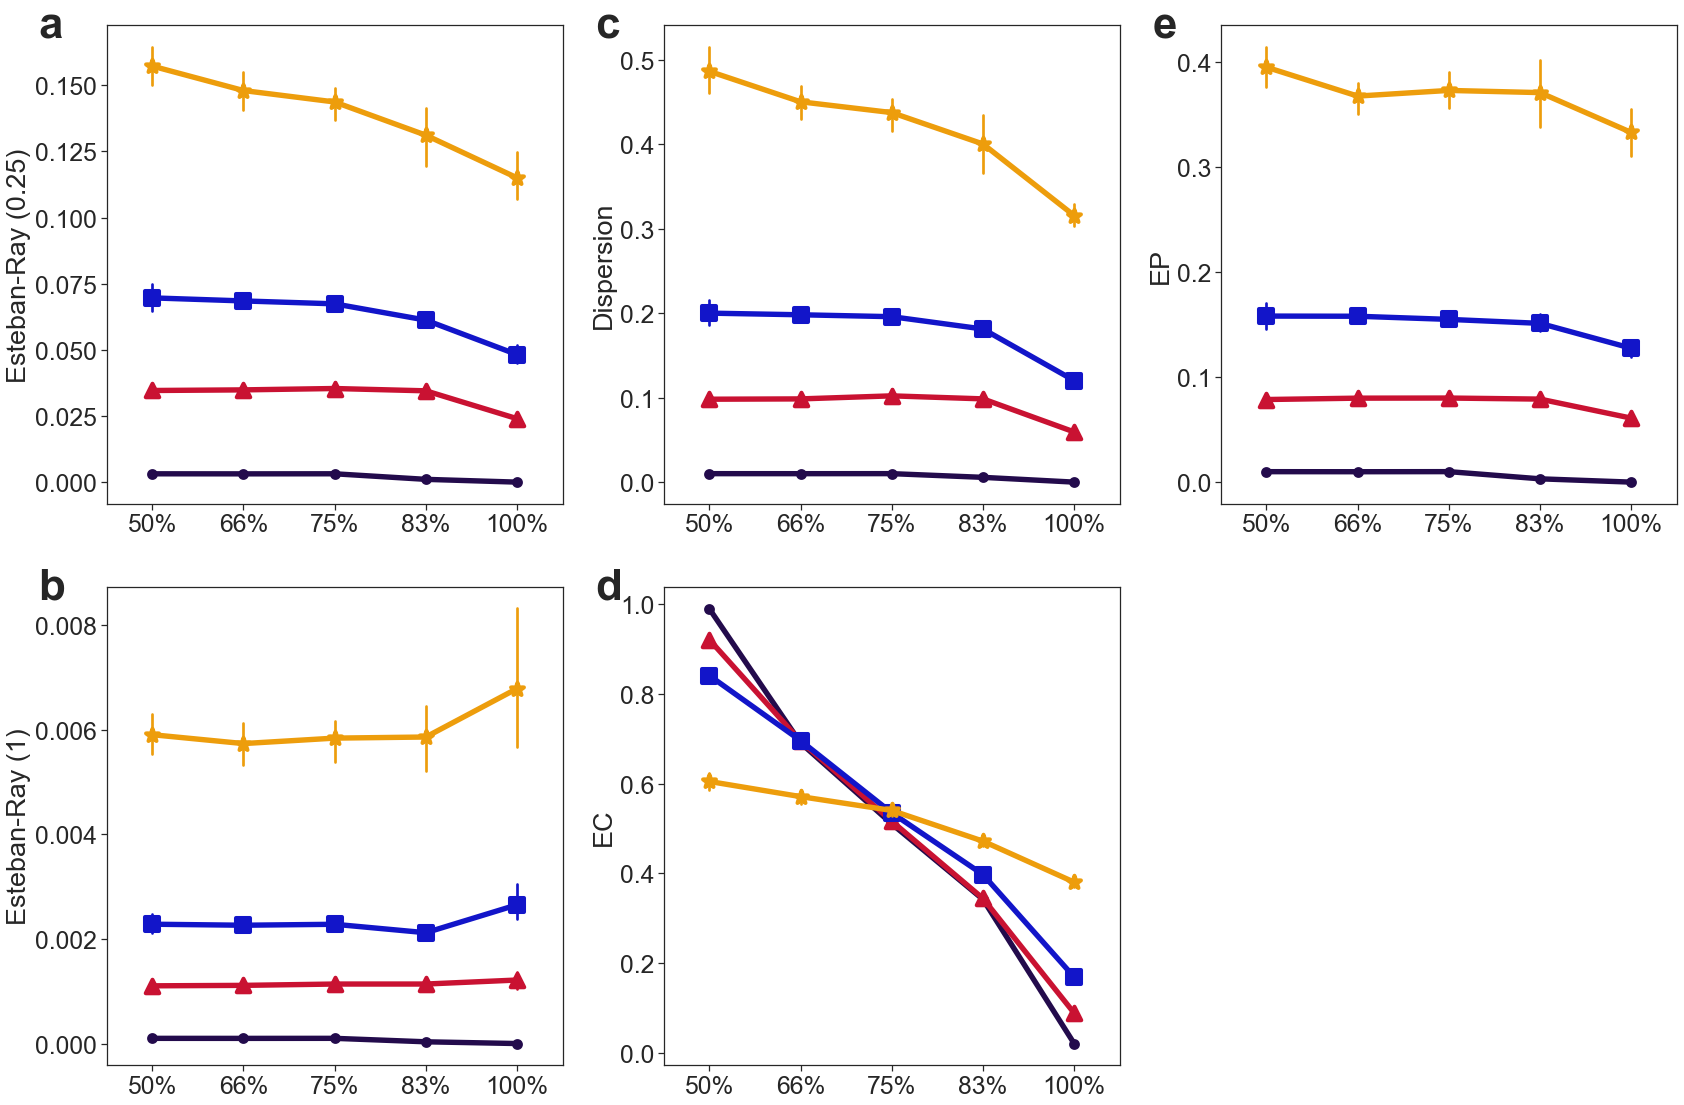

: 

In [38]:
sns.set(font_scale=2.25, style="ticks")

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 16))
labels = list("abcdefghijklm")

i = 0
for idx, item in enumerate([
    ("Esteban-Ray (0.25)", df_ER),
    ("Esteban-Ray (1)", df_ER2),
    # ("Wang-Tsui (0.5)", df_TW),
    # ("Wang-Tsui (0.75)", df_TW2),
    # ("Blais-Lago", blais_lago_v),
    # ("Blais-Lago", blais_lago_v),
    # ("Blais-Lago", blais_lago_v),
    ("Dispersion", df_DP),
    ("EC", df_BW),
    ("EP", df_WT),
    # ("EP", df_EP),
    # ("Reynal-Querol", df_RQ)
]):
    label, df_item = item
    df_item = df_item.copy()
    df_item["mu"] = df_item["mu"].apply(lambda x: f"{int(x * 100)}%")
    ax = axs[idx%2, int(idx/2)]#
    sns.pointplot(
        x="mu", hue="sigma", 
        scale=2, y="value", 
        markers=[".", "^", "s", "*"], 
        palette=["#230B4C", "#C91232", "#1215C9", "#ED9D0C"], 
        data=df_item, ax=ax)
    # ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax.set_ylabel(label)
    ax.set_xlabel("")
    ax.text(-0.15, 0.975, labels[i], fontsize=44, transform=ax.transAxes, fontweight=700)
    i += 1

    leg = ax.legend()
    leg.remove()

# sns.despine(offset=10, trim=True)
# 

axs[1, 2].axis("off")
fig.tight_layout()
fig.savefig(f"Figures_Appendix/Comparison_Polarization_Simulations.pdf")


In [ ]:
from scipy.stats import pearsonr

polarization = [
    ("Esteban-Ray (0.25)", df_ER),
    ("Esteban-Ray (1)", df_ER2),
    # ("Wang-Tsui (0.5)", df_TW),
    # ("Wang-Tsui (0.75)", df_TW2),
    ("Blais-Lago", blais_lago_v),
    ("Dispersion", df_DP),
    ("Between-EP", df_BW),
    ("Within-EP", df_WT),
    # ("EP", df_EP),
    ("Reynal-Querol", df_RQ)
]

output = []
df_output = []
for mu in df_ER.mu.unique():
    for sigma in df_ER.sigma.unique():
        for xx in polarization:
            x1 = xx[1]
            x1 = x1[(x1["mu"] == mu) & (x1["sigma"] == sigma)]
            for yy in polarization:
                y1 = yy[1]
                y1 = y1[(y1["mu"] == mu) & (y1["sigma"] == sigma)]

                if xx[0] != yy[0]:
                    try:
                        value, pvalue = pearsonr(x1["value"], y1["value"])
                        output.append({
                            "value": value,
                            "pvalue": pvalue,
                            "xx": xx[0],
                            "yy": yy[0],
                            "mu": mu,
                            "sigma": sigma
                        })
                    except:
                        pass

        tmp = pd.DataFrame(output)
        # tmp["mu"] = mu
        df_output.append(tmp)

data = pd.concat(df_output).drop_duplicates()
data

C:\Users\cnava\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


,value,pvalue,xx,yy,mu,sigma
0,1.000000,6.582110e-11,Esteban-Ray (0.25),Esteban-Ray (1),0.5,0.0025
1,-0.448758,4.484269e-01,Esteban-Ray (0.25),Blais-Lago,0.5,0.0025
2,0.999993,2.315976e-08,Esteban-Ray (0.25),Dispersion,0.5,0.0025
3,0.448768,4.484155e-01,Esteban-Ray (0.25),Between-EP,0.5,0.0025
4,1.000000,3.042667e-10,Esteban-Ray (0.25),Within-EP,0.5,0.0025
...,...,...,...,...,...,...
835,0.214561,7.289228e-01,Reynal-Querol,Esteban-Ray (1),1.0,0.2500
836,-0.999885,1.480713e-06,Reynal-Querol,Blais-Lago,1.0,0.2500
837,0.986318,1.917092e-03,Reynal-Querol,Dispersion,1.0,0.2500
838,0.893533,4.102937e-02,Reynal-Querol,Between-EP,1.0,0.2500


In [ ]:
data[(data["xx"] == "Within-EP") & ~(data["yy"].isin(["Between-EP", "Within-EP"]))]

,value,pvalue,xx,yy,mu,sigma
30,1.000000,3.042667e-10,Within-EP,Esteban-Ray (0.25),0.5,0.0025
31,0.999999,1.246983e-09,Within-EP,Esteban-Ray (1),0.5,0.0025
32,-0.449558,4.475173e-01,Within-EP,Blais-Lago,0.5,0.0025
33,0.999996,1.038004e-08,Within-EP,Dispersion,0.5,0.0025
35,0.495851,3.955837e-01,Within-EP,Reynal-Querol,0.5,0.0025
...,...,...,...,...,...,...
828,0.903521,3.544851e-02,Within-EP,Esteban-Ray (0.25),1.0,0.2500
829,0.393339,5.124166e-01,Within-EP,Esteban-Ray (1),1.0,0.2500
830,-0.934463,1.994117e-02,Within-EP,Blais-Lago,1.0,0.2500
831,0.980617,3.230034e-03,Within-EP,Dispersion,1.0,0.2500


Text(0, 0.5, '')

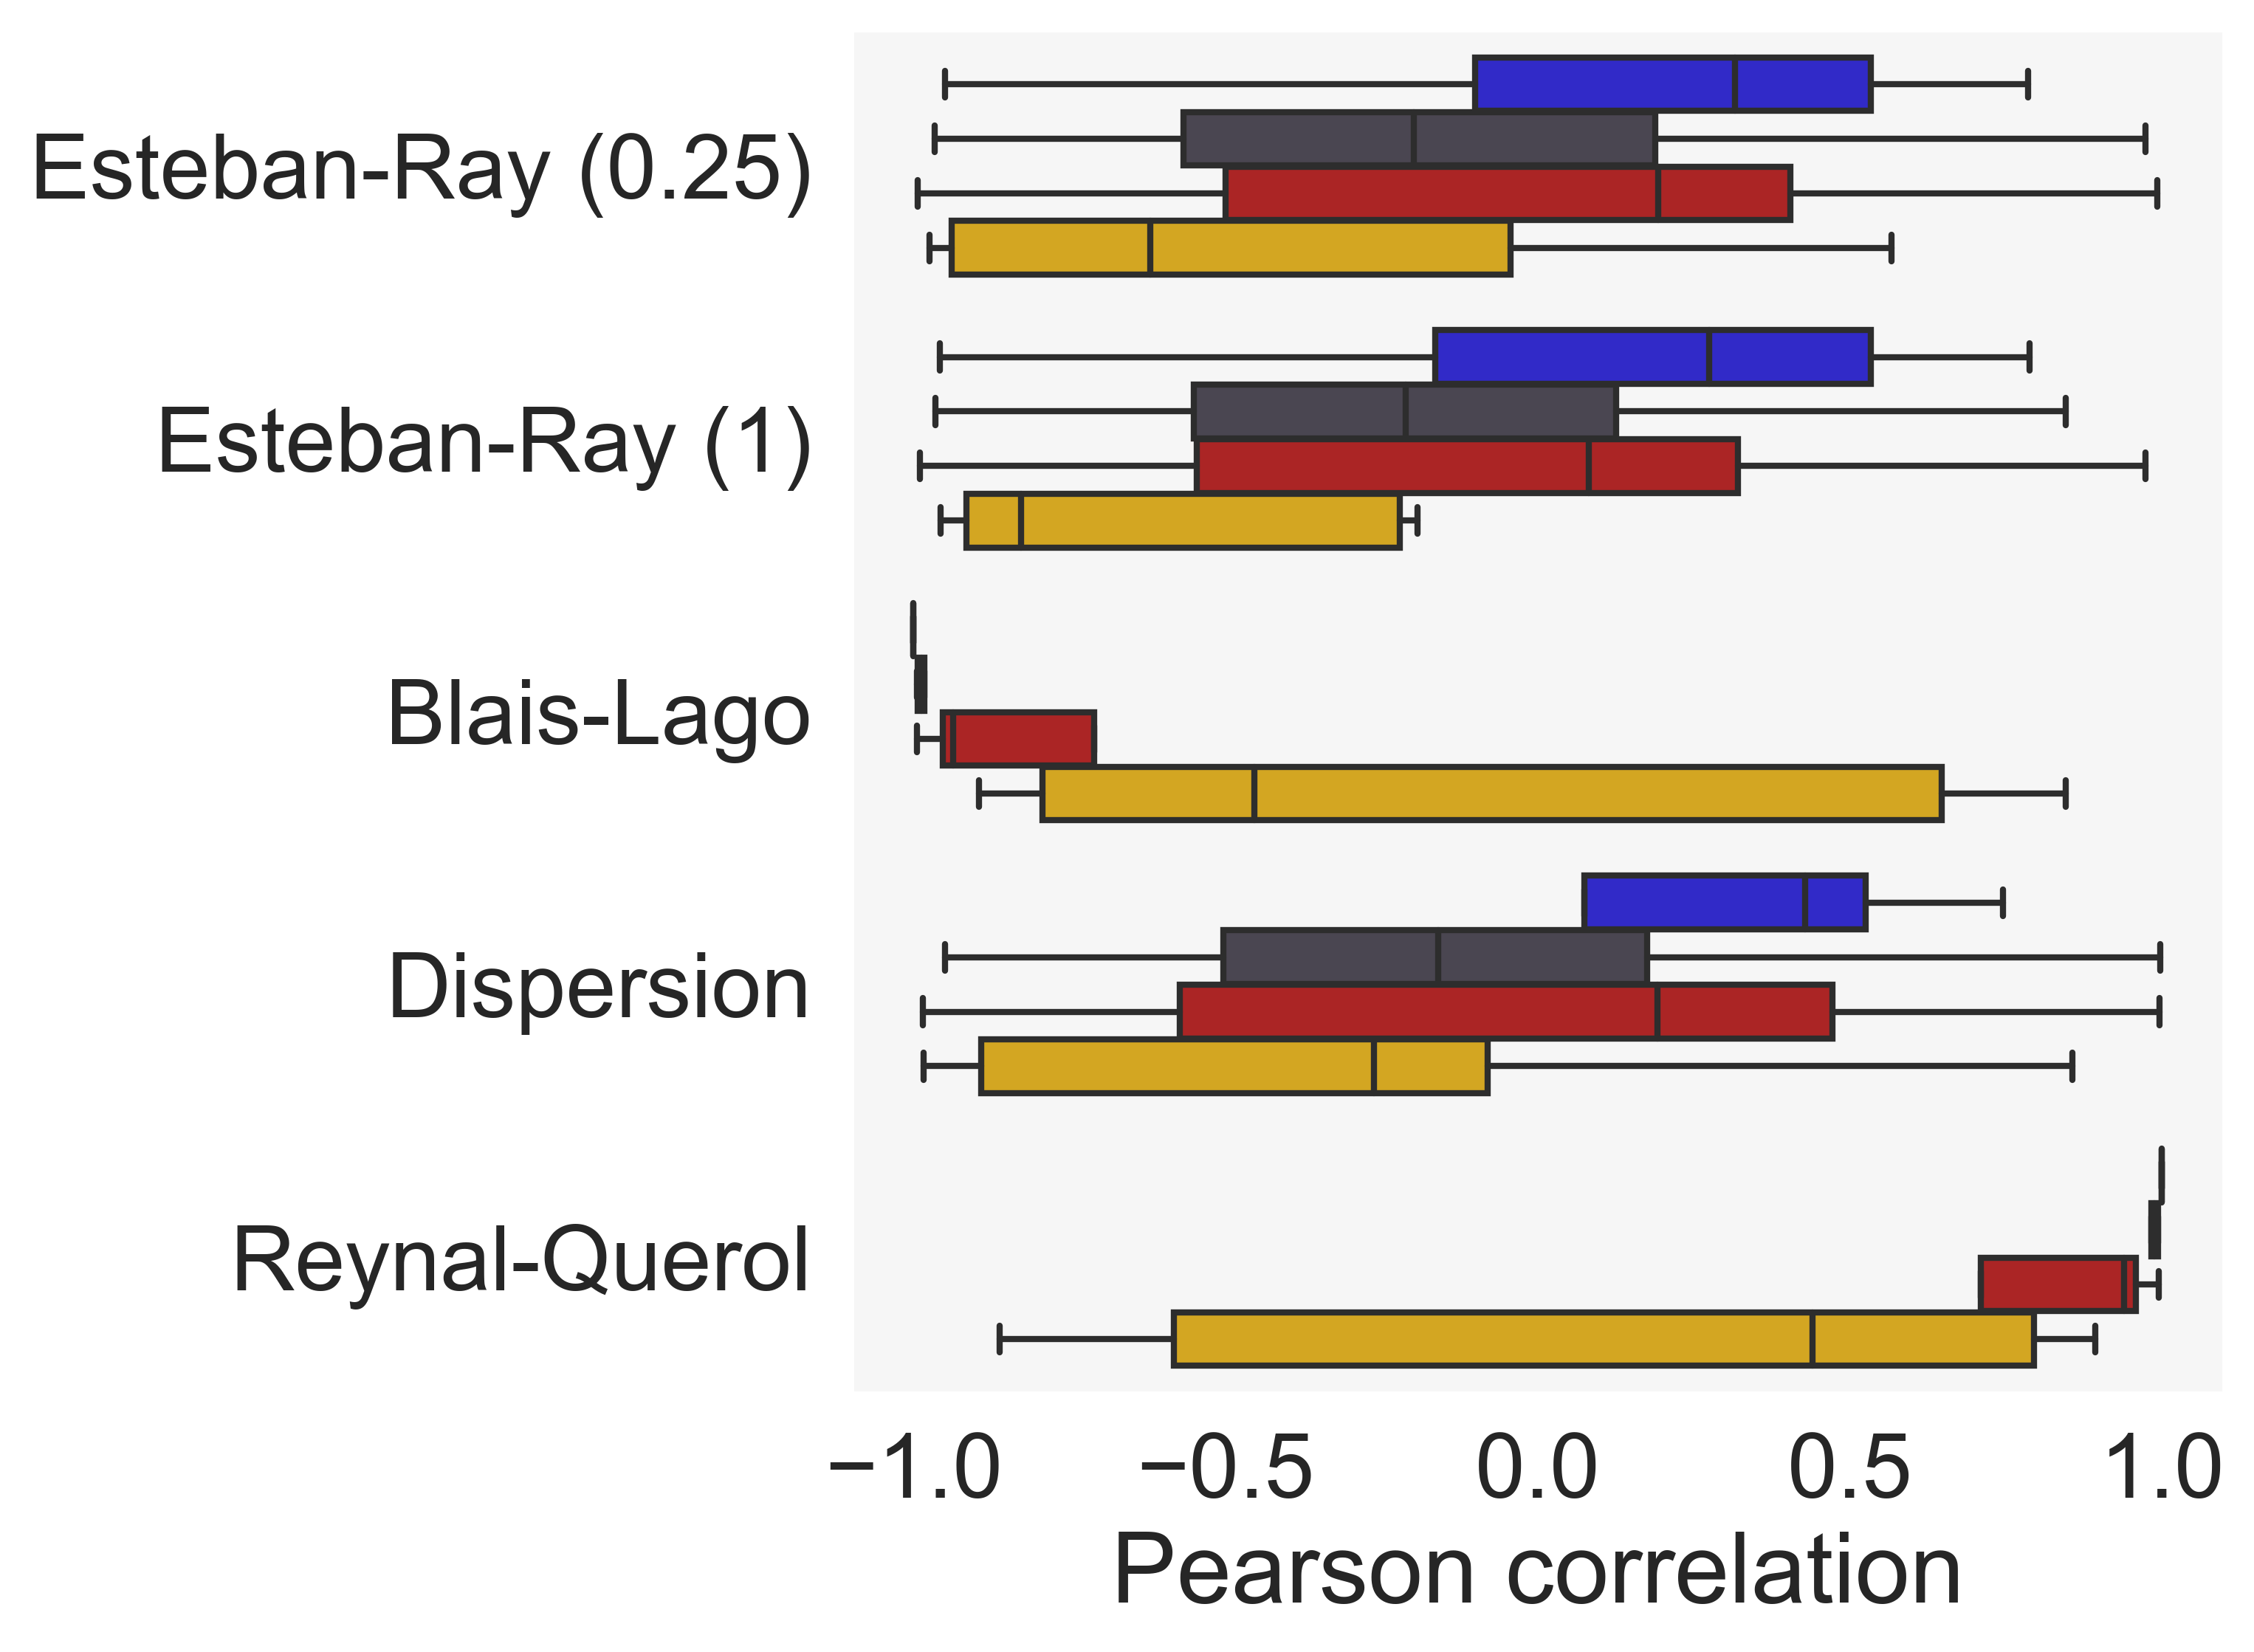

In [ ]:
sns.set(font_scale=2, rc={"axes.facecolor": "#f6f6f6", "axes.grid" : False})

fig, ax = plt.subplots(figsize=(6, 6), dpi=400)

ax = sns.boxplot(
    y="yy",
    x="value",
    hue="sigma",
    showfliers=False,
    palette=["#1910E2", "#4A4453", "#C10F0F", "#F0B505", "#007A1A"],
    data=data[(data["xx"] == "Between-EP") & ~(data["yy"].isin(["EP", "Between-EP", "Within-EP"]))]
)

# plt.xticks(rotation=90)
leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
leg.remove()
ax.set_xlabel("Pearson correlation")
ax.set_ylabel("")

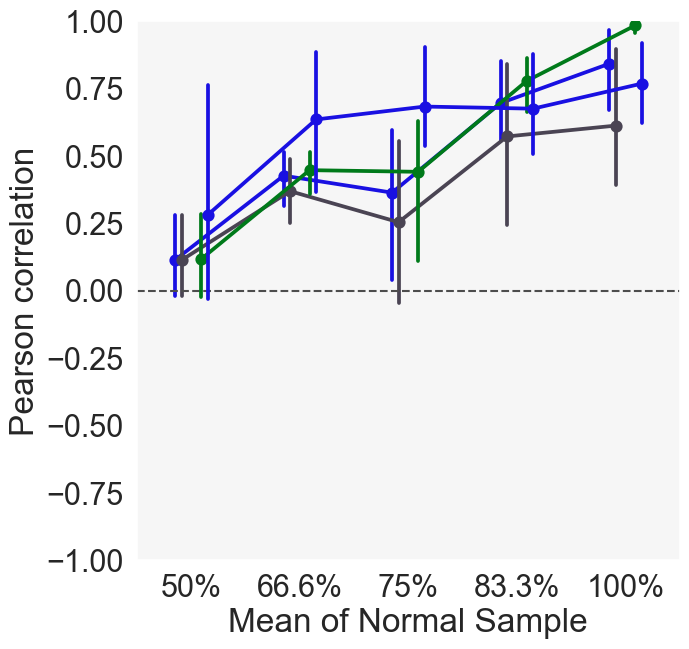

In [ ]:
sns.set(font_scale=2, rc={"axes.facecolor": "#f6f6f6", "axes.grid" : False})

order = ["Esteban-Ray (0.25)", "Esteban-Ray (1)", "Tsui-Wang (0.5)", "Tsui-Wang (0.75)", "Dispersion", "Reynal-Querol"]

fig, ax = plt.subplots(figsize=(7, 7))
sns.pointplot(x="mu", y="value", hue="yy", dodge=0.3, hue_order=order,
    palette=["#1910E2", "#4A4453", "#C10F0F", "#F0B505", "#007A1A"],
    data=data[(data["xx"] == "EP") & ~(data["yy"].isin(["EP", "Between-EP", "Within-EP"]))])
ax.axhline(y=0, ls="--", c=".3")
ax.set_ylabel("Pearson correlation")
ax.set_xlabel("Mean of Normal Sample")
ax.set_xticklabels(["50%", "66.6%", "75%", "83.3%", "100%"])
ax.set_ylim(-1, 1)
lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
lgd.remove()